In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
!pip install unidecode
!pip install gensim==4.3.1
!pip install fasttext
!pip install tensorflow

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fasttext
Failed to build fasttext


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\dist.py:771: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
    warnings.warn(
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\fasttext
  copying python\fasttext_module\fasttext\FastText.py -> build\lib.win-amd64-cpython-311\fasttext
  copying python\fasttext_module\fasttext\__init__.py -> build\lib.win-amd64-cpython-311\fasttext
  creating build\lib.win-amd64-cpython-311\fasttext\util
  copying python\fasttext_module\fasttext\util\util.py -> build\lib.win-amd64-cpython-311\fasttext\util
  copying python\fasttext_module\fasttext\util\__init__.py -> 

In [25]:
import gensim
import re
import logging
import numpy as np
import pandas as pd
import multiprocessing

from re import sub
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split


In [26]:
#data loading
# we load all the rows(~600k)
colnames=['comment'] 
hiphop = pd.read_csv("hiphopheads.csv", on_bad_lines='skip',engine='python', header = None, names = colnames)
jazz = pd.read_csv("jazz.csv", on_bad_lines='skip',engine='python', header = None, names = colnames)
punk = pd.read_csv("punk.csv", on_bad_lines='skip',engine='python', header = None, names = colnames)
metal = pd.read_csv("metal.csv", on_bad_lines='skip',engine='python', header = None, names = colnames)
classical = pd.read_csv("classicalmusic.csv", on_bad_lines='skip',engine='python', header = None, names = colnames)

In [27]:
fileList2 = []
#as explained in the README.md, we only use a subset of the scraped data
fileList2.append(hiphop.sample(2000))
fileList2.append(jazz.sample(2000))
fileList2.append(punk.sample(2000))
fileList2.append(metal.sample(2000))
fileList2.append(classical.sample(2000))

In [28]:
# we merge all dataframes into one
merge = pd.concat(fileList2)

fileList = []
fileList.append(merge)

print(type(merge))
print(merge)

<class 'pandas.core.frame.DataFrame'>
                                                      comment
t1_j9clzzv  Can't tell if you're joking or not but if not ...
t1_jbb0vn7  Does anyone actually care about Budden anymore...
t1_jdxrlo6  Want another crazy thought? Jim Jones once tri...
t1_jd85zf1  He's working out at LA Fitness....\n\nHe ain't...
t1_jaxxcnw  YG’s scared money ft J.Cole and Moneybagg Yo. ...
...                                                       ...
t1_imefibx  We literally have Robert telling her he doesn’...
t1_j31yzqy  Fikret Amirov. Not a huge collection but a gor...
t1_iu0ie0a  5, mainly for [the epic cadenza](https://youtu...
t1_jhpqizv  Artists. All artists are nepo babies nowadays ...
t1_ir37fui  Have you tried Brahms' Symphony 3, III Poco Al...

[10000 rows x 1 columns]


In [29]:
print(fileList)

[                                                      comment
t1_j9clzzv  Can't tell if you're joking or not but if not ...
t1_jbb0vn7  Does anyone actually care about Budden anymore...
t1_jdxrlo6  Want another crazy thought? Jim Jones once tri...
t1_jd85zf1  He's working out at LA Fitness....\n\nHe ain't...
t1_jaxxcnw  YG’s scared money ft J.Cole and Moneybagg Yo. ...
...                                                       ...
t1_imefibx  We literally have Robert telling her he doesn’...
t1_j31yzqy  Fikret Amirov. Not a huge collection but a gor...
t1_iu0ie0a  5, mainly for [the epic cadenza](https://youtu...
t1_jhpqizv  Artists. All artists are nepo babies nowadays ...
t1_ir37fui  Have you tried Brahms' Symphony 3, III Poco Al...

[10000 rows x 1 columns]]


In [30]:
# data cleaning helper methods, exactly the same as in class
def text_to_word_list(text, remove_polish_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = remove_polish_letters(text)
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", "", text)
    text = sub(r",", "", text)
    text = sub(r"\.", "", text)
    text = sub(r"!", "", text)
    text = sub(r"\?", "", text)
    text = sub(r"'", "", text)
    text = sub(r":", "", text)
    text = sub(r"\s{2,}", " ", text)

    text = text.split()

    return text  

In [31]:
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [32]:
# data cleaning helper methods, exactly the same as in class

def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.title.split()))

In [33]:
# data cleaning helper methods, exactly the same as in class

def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [34]:
predictedList = []

In [35]:
def divide_to_parts(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

# the code below uses a slight hack and requires explanation
# when using large dataframes(more than 6k rows) the model would label 
# all rows the same.
# For smaller dataframes, however, the model would work correctly
# That's why we divide the dataframes into smaller chunks, and then merge them together after

for file_ in fileList:
  parts = divide_to_parts(file_.comment, 3000)    
  file_['rate'] = 1
  file_cleaned = file_.dropna().drop_duplicates().reset_index(drop=True).rename(columns={'comment':'title'})
  file_cleaned = file_cleaned[file_cleaned.rate!=0]
  file_cleaned.rate.value_counts()/len(file_cleaned)

  file_cleaned.title = file_cleaned.title.apply(lambda x: text_to_word_list(x, unidecode))
  file_model = file_cleaned.copy()
  file_model = file_model[file_model.title.str.len()>1]


  parts = divide_to_parts(file_model.title, 3000)
  for part in parts:    
    #Detect bigrams with gensim's Phraser module.
    sent = [row for row in part]
    phrases = Phrases(sent, min_count=1, progress_per=50000)
    bigram = Phraser(phrases)
    sentences = bigram[sent]

    #word embeddings with CBOW word2vec algorithm found in gensim module
    w2v_model = Word2Vec(min_count=3,
                      window=4,
                      vector_size=300,
                      sample=1e-5, 
                      alpha=0.03, 
                      min_alpha=0.0007, 
                      negative=20,
                      workers=multiprocessing.cpu_count()-1)

    start = time()

    w2v_model.build_vocab(sentences, progress_per=50000)

    print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

    start = time()

    w2v_model.train(sentences,
                    total_examples=w2v_model.corpus_count,
                    epochs=30,
                    report_delay=1)

    print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

    w2v_model.init_sims(replace=True)


    w2v_model.save("word2vec.model")
    
    file_export = file_model.copy()
    file_export['old_title'] = file_export.title
    file_export.old_title = file_export.old_title.str.join(' ')
    file_export.title = file_export.title.apply(lambda x: ' '.join(bigram[x]))
    file_export.rate = file_export.rate.astype('int8')

    file_export[['title', 'rate']].to_csv('cleaned_dataset.csv', index=False)

    # KMeans clusters for sentiment


    word_vectors = Word2Vec.load("word2vec.model").wv

    model = KMeans(n_clusters=2,
                  max_iter=1000,
                  random_state=42,
                  n_init=50)
    model.fit(X=word_vectors.vectors.astype('double'))

    word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

    positive_cluster_index = 1
    positive_cluster_center = model.cluster_centers_[positive_cluster_index]
    negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

    words = pd.DataFrame(word_vectors.index_to_key)
    words.columns = ['words']
    words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
    words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
    words.cluster = words.cluster.apply(lambda x: x[0])
    words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
    words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
    words['sentiment_coeff'] = words.closeness_score * words.cluster_value

    words[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

    #Labelling data

    final_file = pd.read_csv('cleaned_dataset.csv')
    sentiment_map = pd.read_csv('sentiment_dictionary.csv')
    sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

    file_weighting = final_file.copy()
    tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
    tfidf.fit(file_weighting.title)
    features = pd.Series(tfidf.get_feature_names_out())
    transformed = tfidf.transform(file_weighting.title)

    replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)

    replaced_closeness_scores = file_weighting.title.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

    replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.title, file_weighting.rate]).T
    replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']
    replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
    replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
    replacement_df['sentiment'] = [1 if i==1 else 0 for i in replacement_df.sentiment]

    predictedList.append(replacement_df)




Time to build vocab: 0.0 mins
Time to train the model: 0.03 mins


C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\3968851949.py:56: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Time to build vocab: 0.0 mins
Time to train the model: 0.04 mins


C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\3968851949.py:56: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\3968851949.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Time to build vocab: 0.0 mins
Time to train the model: 0.02 mins


C:\Users\Admin\AppData\Local\Temp\ipykernel_25860\3968851949.py:56: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [36]:
# merging the chunks of predictions
merge = pd.concat(predictedList)

tempList = []
tempList.append(merge)

In [37]:
listTwoElems = []

for elem in tempList:
  listTwoElems.append(elem[['sentence', 'prediction']])


In [38]:
# exploring the predictions
print(listTwoElems[0])

                                               sentence  prediction
0     cant tell if_youre joking or not but if not i_...           0
1     does_anyone actually care_about budden anymore...           1
2     want another crazy thought jim jones once trie...           1
3     hes working out at la_fitness he aint a_millio...           1
4     ygs scared money ft jcole and moneybagg yo mon...           1
...                                                 ...         ...
7720  we literally have robert telling her he_doesnt...           0
7721  fikret amirov not a_huge collection but a gorg...           0
7722  5 mainly for the epic cadenza https //youtube/...           0
7723  artists all_artists are nepo babies nowadays d...           0
7724  have you tried brahms symphony 3 iii poco alle...           0

[23175 rows x 2 columns]


In [39]:
# exploring the predictions

with pd.option_context('display.max_colwidth', None):
  display(listTwoElems[0])

,sentence,prediction
0,cant tell if_youre joking or not but if not i_feel old as shit and im like 24,0
1,does_anyone actually care_about budden anymore lost me with the_animal abuse then i heard nothing but bs drama with the crew,1
2,want another crazy thought jim jones once tried_to get his_own reality show setting off a chain of events that led to the entire invasion of privacy tracklist going platinum,1
3,hes working out at la_fitness he aint a_millionaire,1
4,ygs scared money ft jcole and moneybagg yo moneybagg didnt_even seem_to try to_stay on beat,1
...,...,...
7720,we literally have robert telling her he_doesnt want her to tour and that he wants her to_focus on wifely duties his_own words in his_own writing and youre still skeptics im_not surprised tbh,0
7721,fikret amirov not a_huge collection but a gorgeously unique one straight_from the soviet union,0
7722,5 mainly for the epic cadenza https //youtube/w1rud9wvodc but also a sweet 3rd_movement but i_adore them all,0
7723,artists all_artists are nepo babies nowadays dontchaknow,0


ETAP 2: CLASSIC ML

In [40]:
# All the lists below contain only a single element
# The list would be required if we were comparing sentiments between different genres
# We ended up leaving the current implementation, instead of refactoring it to only support analysis of a single dataframe
historyZeroList = []
historyOneList = []
historyTwoList = []
historyThreeList = []
historyNeural = []

In [41]:
cm0 = []
cm1 = []
cm2 = []
cm3 = []
cmNeural = []

In [42]:
roc0 = []
roc1 = []
roc2 = []
roc3 = []
rocNeural = []

In [43]:
actualY = []

y0 = []
y1 = []
y2 = []
y3 = []
yNeural = []

In [44]:
max_words = 5000
max_lenght = 200
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

for data in listTwoElems:
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(data.sentence)
    sequences = tokenizer.texts_to_sequences(data.sentence)
    tweets = pad_sequences(sequences, maxlen=max_lenght)
    labels = to_categorical(data.prediction, num_classes=2)
    X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.1, stratify=labels, random_state=42)

    actualY.append(y_test)

    print("Caclulating model DecisionTreeClassifier")
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train)
    dt_predictions = dt_model.predict(X_test)

    dt_conf = confusion_matrix(y_test.argmax(axis=1), dt_predictions.argmax(axis=1))
    roc_dt = roc_auc_score(y_test, dt_predictions)

    print("Caclulating model RandomForestClassifier")
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)

    rf_conf = confusion_matrix(y_test.argmax(axis=1), rf_predictions.argmax(axis=1))
    roc_rf = roc_auc_score(y_test, rf_predictions)

    print("Caclulating model 0")

    model0 = Sequential()
    model0.add(layers.Embedding(max_words, 20))
    model0.add(layers.LSTM(5))
    model0.add(layers.Dense(64, activation='relu'))
    model0.add(layers.Dense(2, activation='softmax'))

    model0.compile(optimizer="rmsprop",
                   loss="categorical_crossentropy",
                   metrics=['accuracy']
                   )

    history0 = model0.fit(X_train,
                          y_train,
                          epochs=10,
                          validation_data=(X_test, y_test)
                          )

    neuralPred = model0.predict(X_test)
    confusionMtrx = confusion_matrix(y_test.argmax(axis=1), neuralPred.argmax(axis=1))
    rocAccScore = roc_auc_score(y_test, neuralPred)

    y0.append(neuralPred)
    cm0.append(confusionMtrx)
    roc0.append(rocAccScore)
    historyZeroList.append(history0)

    print("Caclulating model 1")

    model = Sequential()
    model.add(layers.Embedding(max_words, 20))
    model.add(layers.LSTM(15, dropout=0.5))
    model.add(layers.Dense(2, activation="softmax"))

    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )

    history1 = model.fit(X_train,
                         y_train,
                         epochs=10,
                         validation_data=(X_test, y_test)
                         )

    neuralPred = model.predict(X_test)
    confusionMtrx = confusion_matrix(y_test.argmax(axis=1), neuralPred.argmax(axis=1))
    rocAccScore = roc_auc_score(y_test, neuralPred)

    y1.append(neuralPred)
    cm1.append(confusionMtrx)
    roc1.append(rocAccScore)
    historyOneList.append(history1)

    print("Caclulating model 2")

    model2 = Sequential()
    model2.add(layers.Embedding(max_words, 40, input_length=max_lenght))
    model2.add(layers.Bidirectional(layers.LSTM(15, dropout=0.6)))
    model2.add(layers.Dense(2, activation="softmax"))

    model2.compile(optimizer="rmsprop",
                   loss="categorical_crossentropy",
                   metrics=['accuracy']
                   )

    history2 = model2.fit(X_train,
                          y_train,
                          epochs=10,
                          validation_data=(X_test, y_test)
                          )

    neuralPred = model2.predict(X_test)
    confusionMtrx = confusion_matrix(y_test.argmax(axis=1), neuralPred.argmax(axis=1))
    rocAccScore = roc_auc_score(y_test, neuralPred)

    y2.append(neuralPred)
    cm2.append(confusionMtrx)
    roc2.append(rocAccScore)
    historyTwoList.append(history2)

    print("Caclulating model 3")

    model3 = Sequential()
    model3.add(layers.Embedding(max_words, 100, input_length=max_lenght))
    model3.add(layers.LSTM(100, return_sequences=True))
    model3.add(layers.LSTM(100))
    model3.add(layers.Dense(64, activation='relu'))
    model3.add(layers.Dense(32, activation='relu'))
    model3.add(layers.Dense(2, activation='softmax'))

    model3.compile(optimizer="rmsprop",
                   loss="categorical_crossentropy",
                   metrics=['accuracy']
                   )

    history3 = model3.fit(X_train,
                          y_train,
                          epochs=10,
                          validation_data=(X_test, y_test)
                          )

    neuralPred = model3.predict(X_test)
    confusionMtrx = confusion_matrix(y_test.argmax(axis=1), neuralPred.argmax(axis=1))
    rocAccScore = roc_auc_score(y_test, neuralPred)

    y3.append(neuralPred)
    cm3.append(confusionMtrx)
    roc3.append(rocAccScore)
    historyThreeList.append(history3)

    # 3: NEURAL MODEL

    print("Caclulating model Neural")

    neuralModel = Sequential()
    neuralModel.add(layers.Embedding(max_words, 40, input_length=max_lenght))
    neuralModel.add(layers.Conv1D(64, 6, activation="relu"))
    neuralModel.add(layers.MaxPool1D(5))
    neuralModel.add(layers.Dropout(0.2))
    neuralModel.add(layers.Conv1D(64, 6, activation="relu"))
    neuralModel.add(layers.GlobalAvgPool1D())
    neuralModel.add(layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    neuralModel.add(layers.Dropout(0.2))
    neuralModel.add(layers.Dense(2, activation="softmax"))
    neuralModel.compile(optimizer="rmsprop",
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])

    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
    neuralHistory = neuralModel.fit(X_train,
                                    y_train,
                                    epochs=25,
                                    validation_data=(X_test, y_test),
                                    callbacks=[es])

    neuralPred = neuralModel.predict(X_test)
    confusionMtrx = confusion_matrix(y_test.argmax(axis=1), neuralPred.argmax(axis=1))
    rocAccScore = roc_auc_score(y_test, neuralPred)

    yNeural.append(neuralPred)
    cmNeural.append(confusionMtrx)
    rocNeural.append(rocAccScore)
    historyNeural.append(neuralHistory)


Caclulating model DecisionTreeClassifier
Caclulating model RandomForestClassifier
Caclulating model 0
Epoch 1/10
652/652 [==============================] - 21s 31ms/step - loss: 0.5080 - accuracy: 0.7934 - val_loss: 0.4895 - val_accuracy: 0.7942
Epoch 2/10
652/652 [==============================] - 20s 31ms/step - loss: 0.4861 - accuracy: 0.7943 - val_loss: 0.4865 - val_accuracy: 0.7968
Epoch 3/10
652/652 [==============================] - 20s 30ms/step - loss: 0.4776 - accuracy: 0.7937 - val_loss: 0.4847 - val_accuracy: 0.7959
Epoch 4/10
652/652 [==============================] - 20s 30ms/step - loss: 0.4713 - accuracy: 0.7934 - val_loss: 0.4866 - val_accuracy: 0.7938
Epoch 5/10
652/652 [==============================] - 20s 30ms/step - loss: 0.4672 - accuracy: 0.7935 - val_loss: 0.4940 - val_accuracy: 0.7955
Epoch 6/10
652/652 [==============================] - 20s 30ms/step - loss: 0.4638 - accuracy: 0.7944 - val_loss: 0.4905 - val_accuracy: 0.7882
Epoch 7/10
652/652 [==============

In [45]:
!pip install plot_keras_history

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/322.1 kB ? eta -:--:--
     -------------                          112.6/322.1 kB 2.2 MB/s eta 0:00:01
     -------------------------------------- 322.1/322.1 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9488 sha256=5e76ee47bebb5a6a370e19b62bb040b120254cb4b0fe11ba69920a030cc6e5db
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\df\78\47\2cdf4aaece3ee5e198bf085b56e5f7980306bf5aec4616f5c1
  Created wheel for sanitize_ml_labels: filename=sanitiz

In [46]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

Decision Tree

In [47]:
print(accuracy_score(actualY[0].argmax(axis=1), dt_predictions.argmax(axis=1)))

0.7446074201898188


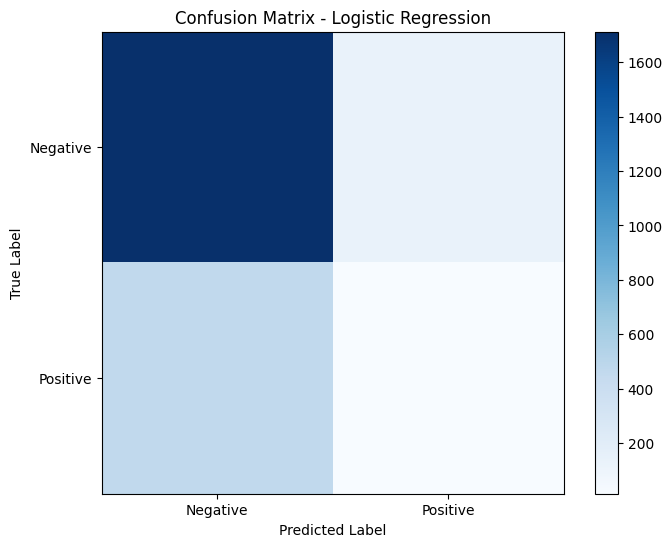

In [48]:
plt.figure(figsize=(8, 6))
plt.imshow(dt_conf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

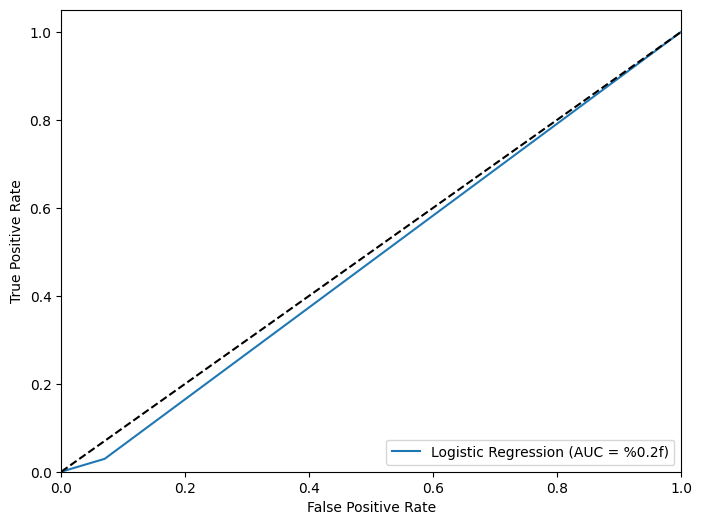

In [49]:
#ROC curve
lr_fpr, lr_tpr, _ = roc_curve(actualY[0].argmax(axis=1), dt_predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

Random Forest

In [50]:
print(accuracy_score(actualY[0].argmax(axis=1), rf_predictions.argmax(axis=1)))

0.7165660051768766


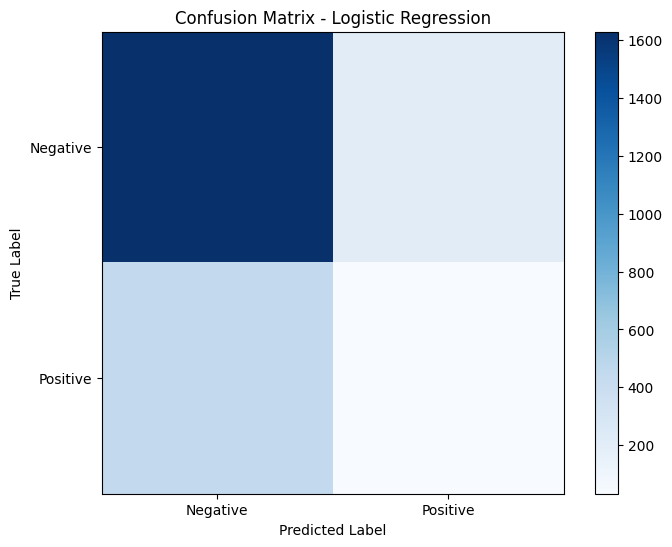

In [51]:
plt.figure(figsize=(8, 6))
plt.imshow(rf_conf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

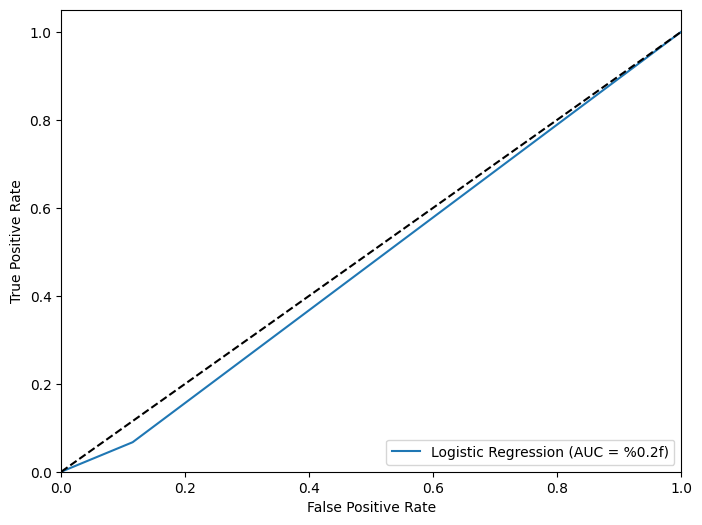

In [52]:
#ROC curve
lr_fpr, lr_tpr, _ = roc_curve(actualY[0].argmax(axis=1), rf_predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

Model ZERO

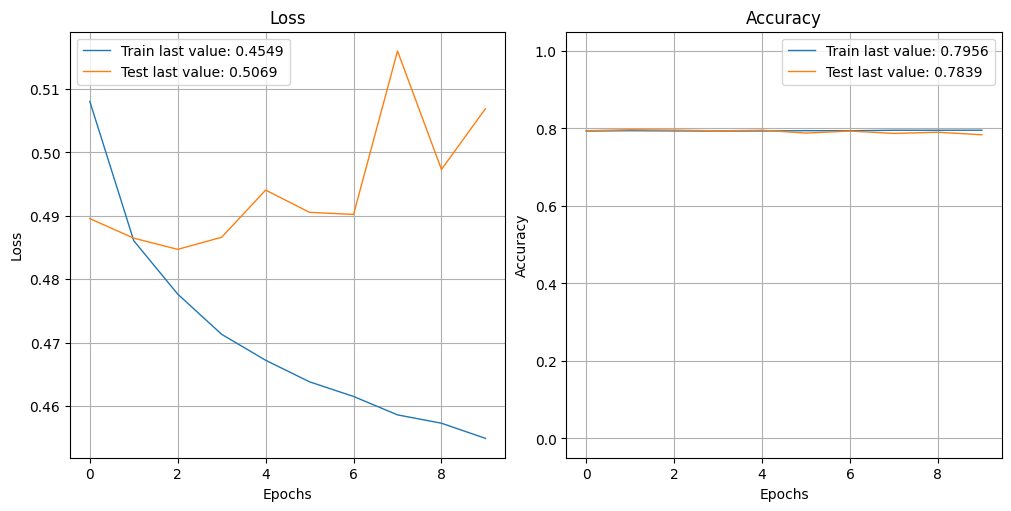

In [53]:

show_history(historyZeroList[0])
plot_history(historyZeroList[0])
plt.close()

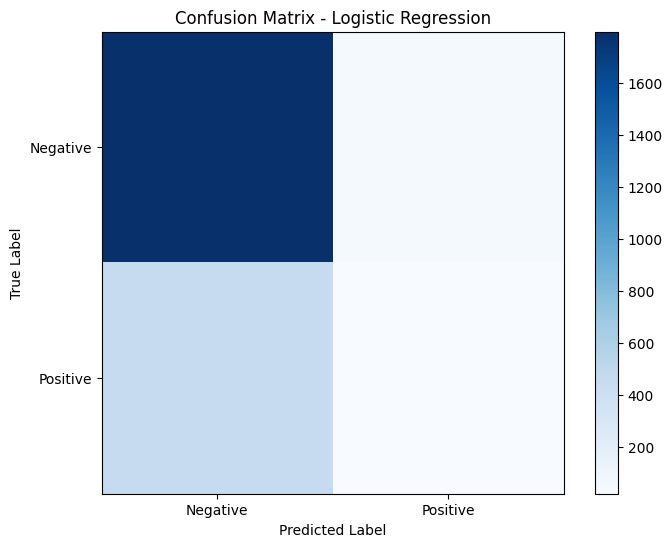

In [54]:
plt.figure(figsize=(8, 6))
plt.imshow(cm0[0], interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

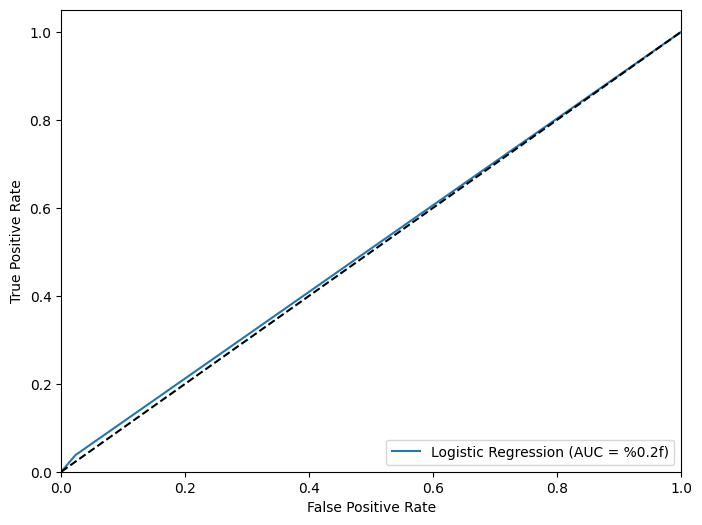

In [55]:
#ROC curve
lr_fpr, lr_tpr, _ = roc_curve(actualY[0].argmax(axis=1), y0[0].argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

MODEL ONE

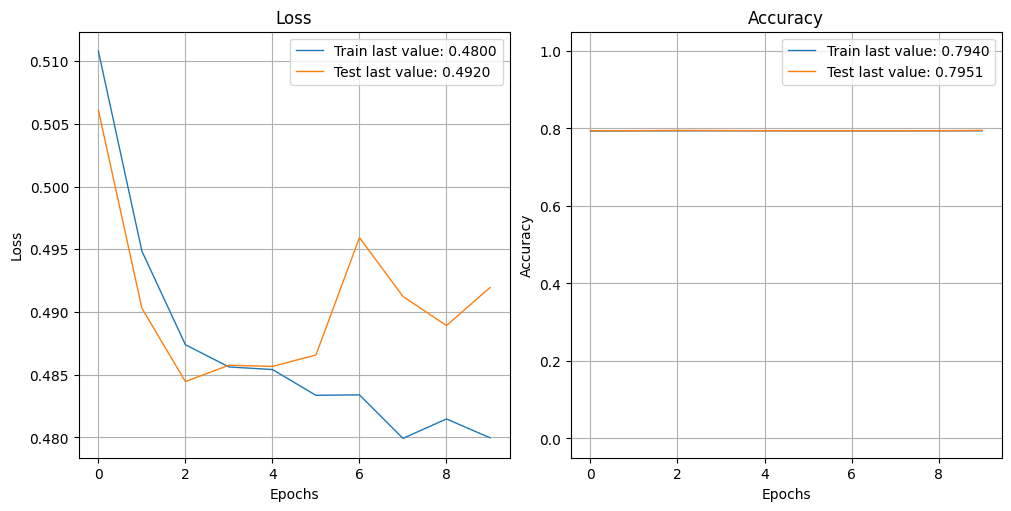

In [56]:
show_history(historyOneList[0])
plot_history(historyOneList[0])
plt.close()

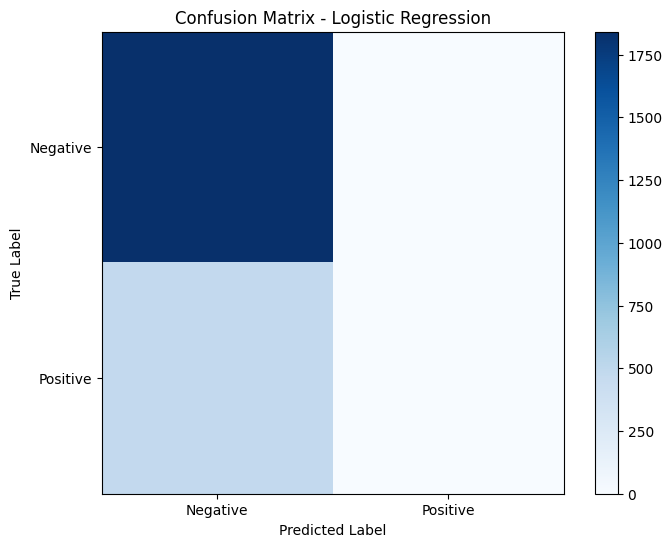

In [57]:
plt.figure(figsize=(8, 6))
plt.imshow(cm1[0], interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

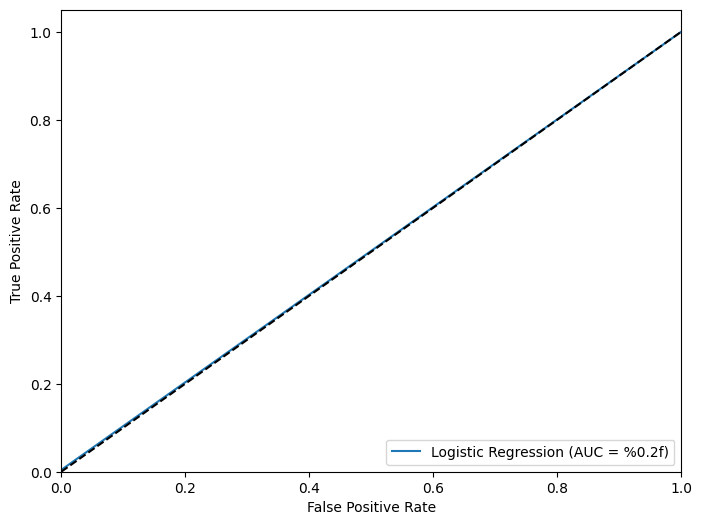

In [58]:
#ROC curve
lr_fpr, lr_tpr, _ = roc_curve(actualY[0].argmax(axis=1), y1[0].argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

MODEL TWO

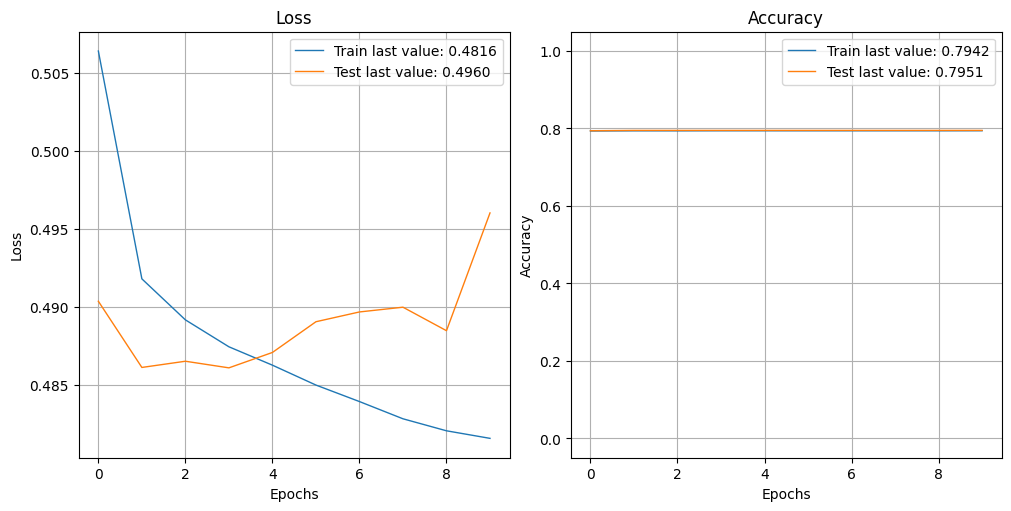

In [59]:
show_history(historyTwoList[0])
plot_history(historyTwoList[0])
plt.close()

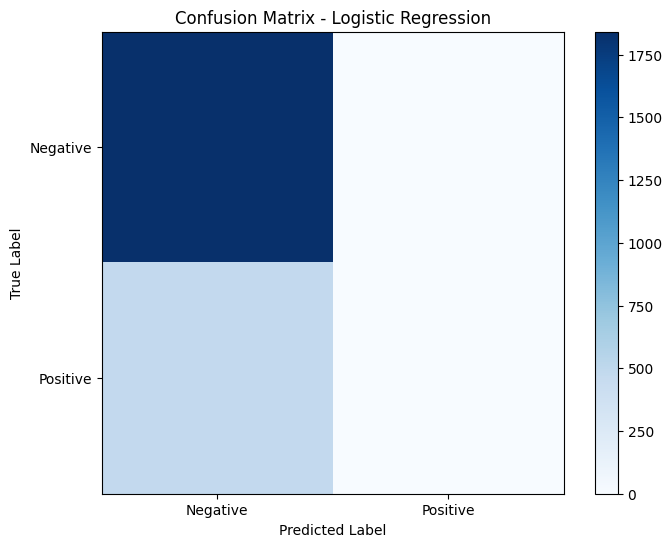

In [60]:
plt.figure(figsize=(8, 6))
plt.imshow(cm2[0], interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

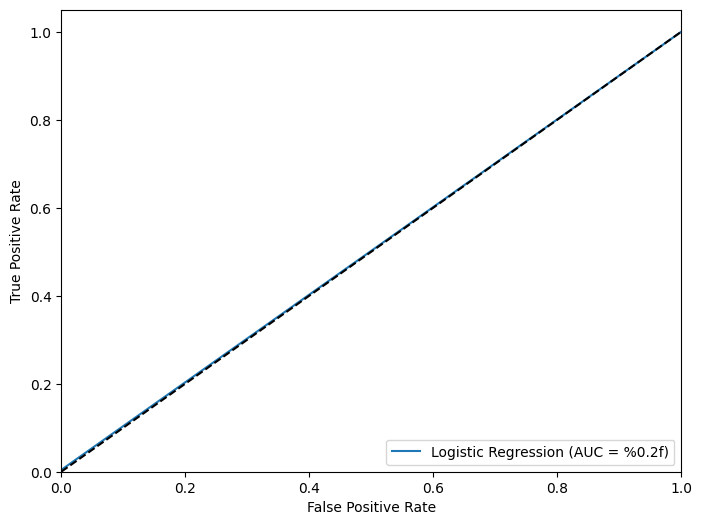

In [61]:
#ROC curve
lr_fpr, lr_tpr, _ = roc_curve(actualY[0].argmax(axis=1), y2[0].argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

MODEL THREE

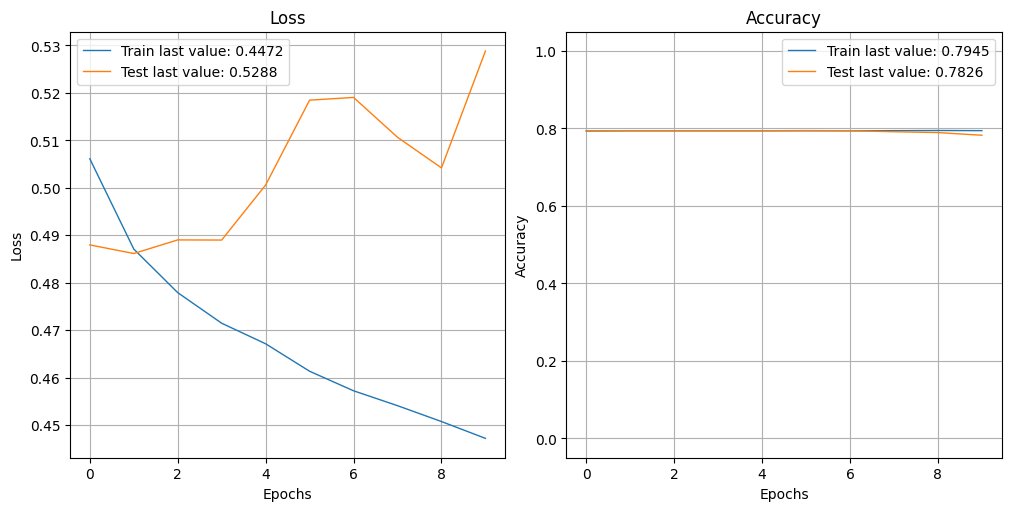

In [62]:
show_history(historyThreeList[0])
plot_history(historyThreeList[0])
plt.close()

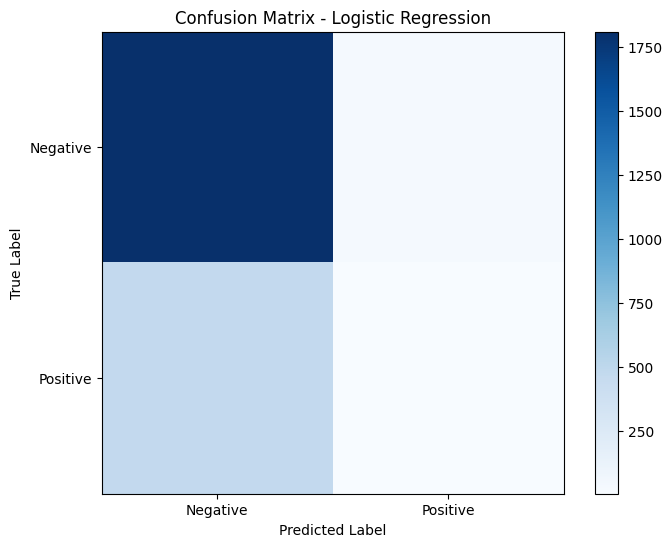

In [63]:
plt.figure(figsize=(8, 6))
plt.imshow(cm3[0], interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

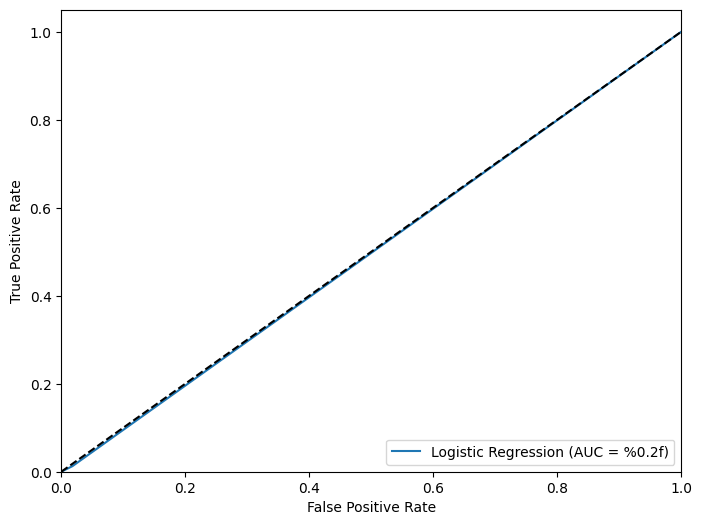

In [64]:
#ROC curve
lr_fpr, lr_tpr, _ = roc_curve(actualY[0].argmax(axis=1), y3[0].argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

MODEL NEURAL

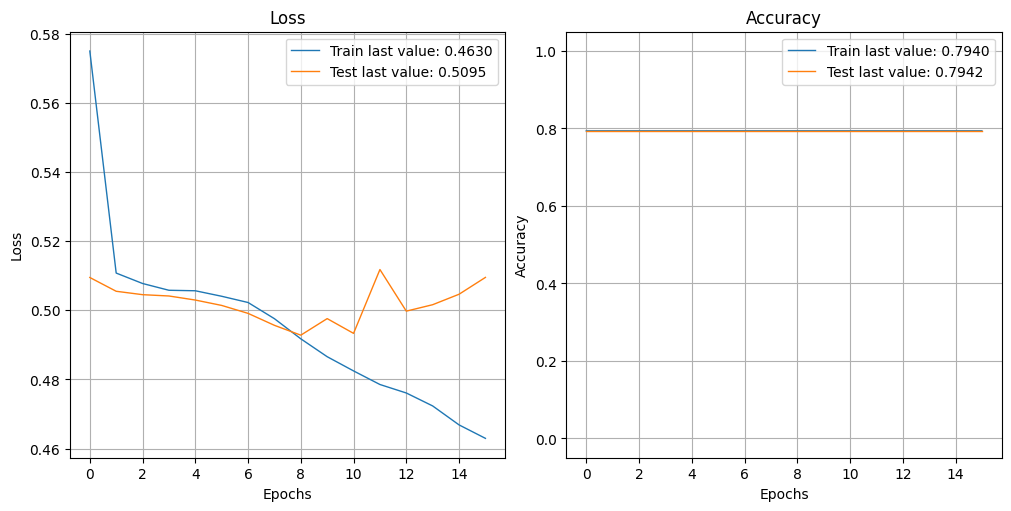

In [65]:
show_history(historyNeural[0])
plot_history(historyNeural[0])
plt.close()

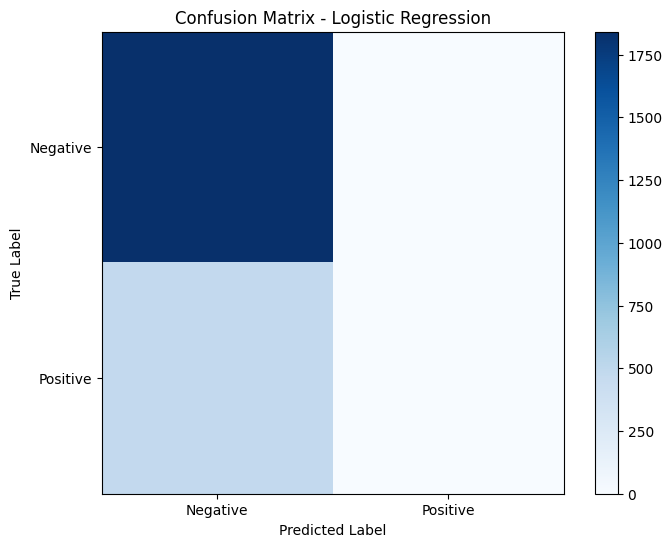

In [66]:
plt.figure(figsize=(8, 6))
plt.imshow(cmNeural[0], interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

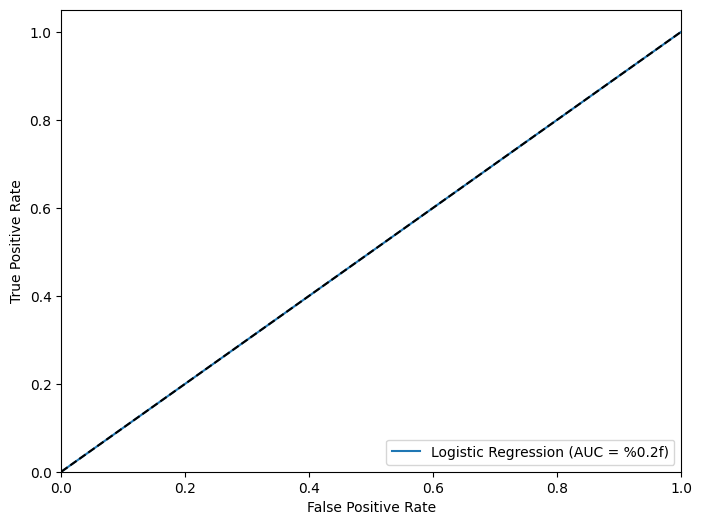

In [67]:
#ROC curve
lr_fpr, lr_tpr, _ = roc_curve(actualY[0].argmax(axis=1), yNeural[0].argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [1]:
# Conclusions
# Most models are overtrained.
# While validation loss is improving(decreasing) during training, but it increases during validation.

# All models predict heavily towards negative comments, although this might be the result of using small dataset.
